# Face Recognition

### !!This is a basic notebook, completing which you can get (preliminarly) 5/10 ponints. Other tasks which will get you more ponts are describes in a Slack channel.

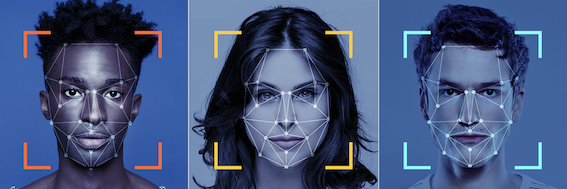

In this project you'll dive into face recognition framework and train neural network for face recognition task, play with losses and metrics.

We will train neural network on [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). 

As you see on the site, images of celebA dataset look like this:


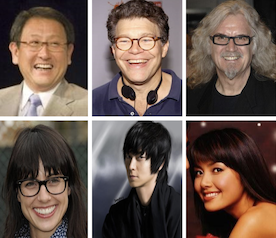

But we won't train a neural network for face recognition on those images. We'll need to preprocess them first. Let's see why we need it and how we need to preprocess them.

Let's look at how face recognition systems work:

## Face recognition model training and inference setup

This section describes how face recognition models are trained, what data alignment is and how the inference of face recognition model looks like. If you are familiar with this, you can skip this section.

### Model training

To train face recognition model on any facial dataset images must be aligned first. This step is very important to achieve a good quality of face recognition.

What is alignment: it consists of three steps:
1. Given image, identify facial landmarks on the image (coordinates of eyes, nose and mouth points). Separate neural network can be used there which was trained to identify landmarks on facial images. You can refer to [PyTorch Landmarks tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) to see how this works.
2. Rotate all the images in the dataset so that eyes of the person on every image lie on a certain pre-defined horizontal line.
3. Scale all the images in the dataset so that the size of the faces are approximately identical.

Here's an example of what we would get after alignment of all the images of Aaron Peirsol from our dataset:

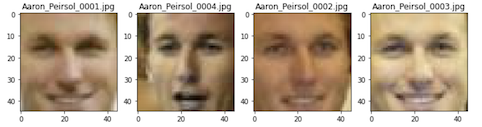

You see that eyes of all the faces lie on one horizontal line and all the faces have almost the same size. If we align all the images in the dataset, we can then train a neural network on aligned images.

**Why we need the alignment procedure**: the alignment of all faces in dataset makes the task of facial recognition easier for the model. If all the faces that model sees are of the same size and have their landmarks (eyes, nose, etc) on almost the same parts of the images, it is easier for the model to learn to identify a person on the image. The model diesn't need to "search" for the face and eyes positions on the image befire performing a recognition.

If you are interested, you can also train a model on non-aligned images, but you'll see that it would perform badly. It is possible though to train a model for face recognition without pre-alignment of all the faces, but this would require a huge amount of data — more that almost any company has. The only company that has openly presented its face recognition system that does not require special alignment is Facebook — their neural network was trained on a really huge amount of data using a special trick to avoid alignment. You can read more details [here](https://research.fb.com/publications/deepface-closing-the-gap-to-human-level-performance-in-face-verification/)

### Model inference

So let's see how the model trained on aligned faces can be used in real world:

Let's assume you owe a company and you want to build a face recognition system for your working office. You decided to hang some cameras around the office and want them to be able to recognize faces of all your employees when they are sitting / walking around the office (we let you decide by yourself why you would need such a system in your office)


A system for face recognition typically conststs of 3 stages:
- face detection
- face alignment
- face recognition

Let's discuss them in detail:

**Face detection**

When the camera is hanged on the wall it records a video and splits the video into single images, like this:

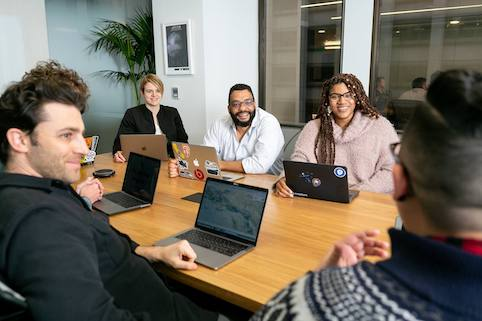

To be able to recognize all the faces on the photo you need first to detect all the faces that are present on the photo, like this:

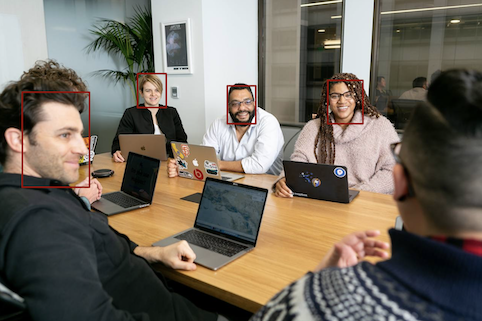

That is the first part — detection. You could use any neural network that can detect humans for this.

**Face alignment**

The second stage is to align all the faces found. The alignment procedure here should be the same as used to align training images.

So we'll get an image of a guy on a photo aligned like this:

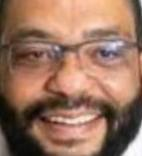

**Face recognition**

On the third stage we use the neural network that we trained to recognize a face.

So that's how the face recognition models pipeline work. You can also read about it more on [this link](https://www.nytimes.com/wirecutter/blog/how-facial-recognition-works/) (and using internet search)

## Neural network model architecture 

Let's discuss how model for face recognition should look like.



The easiest and, actually, the most used way to build a neural network for face recognition is to build it as a **simple classifier**.

Assume we have a dataset with photos of N different people. Then we can build a neural network to classify all the images from the dataset into N classes. Each class refers to one unique person in the dataset.

**How do we recognize new people by this network then?** We actually want the network for face recognition to be able to recognize not only the people which are in training set, but almost every person in the world.

That is how: after training the model, we'll drop it's last classification layer. After that when we'll pass an image of the person through network, we'll get the output of the pre-last layer — it's **the embedding of the image**. Having embeddings of two different images we can compare them using **cosine distance**. The less the distance is — the higher the probability that those two photos belong to one person is. 

Using that technique we can get embeddings of every image — even of unseen people, compare them, and reveal images belonging to same people. 

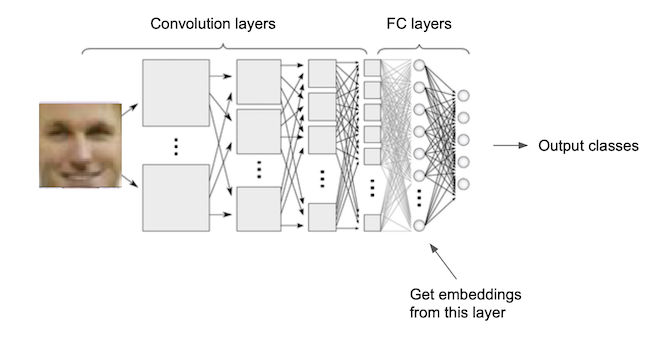

## Task 1 (30% points): build a neural network for faces classification as discribed above.

### Dataset 

We will train out face recognition network on part of the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). But we'll use a version of it that has all the images in it aligned and cropped. You can download the dataset using this link: https://disk.yandex.ru/d/S8f03spLIA1wrw

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
!unzip -q /content/gdrive/MyDrive/celebA_train_1k.zip

Let's look at the data first:

In [1]:
! ls celebA_train_1k/

celebA_anno.txt  celebA_imgs  celebA_train_split.txt


- celebA_imgs — folder with aligned images 
- celebA_anno.txt — file with annotations: which person each image corresponds to
- celebA_train_split.txt — file with train/val/test info

In [2]:
import os
import cv2
import numpy as np
from PIL import Image
from skimage import io, transform

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

from tqdm import tqdm, tqdm_notebook
import torch.nn as nn

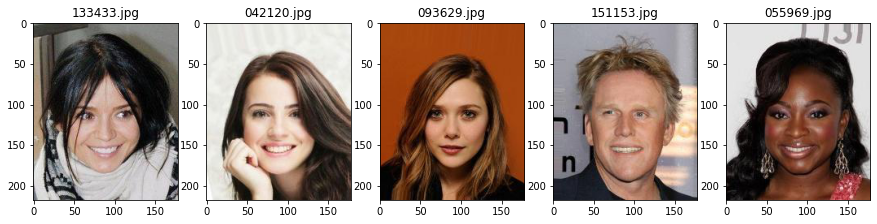

In [3]:
def show_imgs(images_names):
    imgs = []
    for img in images_names:
      img = Image.open(os.path.join('celebA_train_1k/celebA_imgs/', img))
      imgs.append(np.array(img))

    f, axes= plt.subplots(1, len(imgs), figsize=(3*len(imgs),5))
    for i, axis in enumerate(axes):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].set_title(images_names[i])
    plt.show()

images_names = os.listdir('./celebA_train_1k/celebA_imgs/')[:5]
show_imgs(images_names)


### Train Neural Network

Let's build a Datasets and network using this images:

In [4]:
def get_paths(dataset_type='train'):
    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('celebA_train_1k/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:            
        images_paths.append(os.path.join('celebA_train_1k/celebA_imgs/', filename))
    
    return np.array(images_paths)


class celebADataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, dataset_type, transform, aug=None,):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('celebA_train_1k/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:int(y) for x, y in labels}
        self.labels = [labels[x.split('/')[-1]] for x in self.images]

        self.transform = transform
        self.aug = aug
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        img_name = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(img_name) 
        
        if self.aug:
            sample = self.aug(
                image=image,
            )
        else:
            sample = {
                'image': image,
                'label': label,
            }
        
        sample['image'] = self.transform(sample['image'])

        return sample

    def get_imgs(self, number):
        pics = []
        for i, j in enumerate(self.labels):
            if j == number:
                pics.append(self.images[i])
        if len(pics) != 0:
            pics = torch.stack([self.transform(Image.open(x)) for x in pics])
        else:
            pics = torch.Tensor()
        return pics

In [5]:
transform_for_train = transforms.Compose([
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.RandomHorizontalFlip(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform = transforms.Compose([
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_data = celebADataset('train', transform_for_train)
val_data = celebADataset('val', transform)
test_data = celebADataset('test', transform)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

We'll use pretrained on VGGFace2 network InceptionResnetV1 from here: https://github.com/timesler/facenet-pytorch/tree/master/models

In [8]:
! git clone https://github.com/timesler/facenet-pytorch.git
! mv facenet-pytorch/models ./

Cloning into 'facenet-pytorch'...
remote: Enumerating objects: 1267, done.
remote: Total 1267 (delta 0), reused 0 (delta 0), pack-reused 1267
Receiving objects: 100% (1267/1267), 22.88 MiB | 13.27 MiB/s, done.
Resolving deltas: 100% (619/619), done.


In [6]:
! ls models

inception_resnet_v1.py	mtcnn.py  __pycache__  utils


In [7]:
from models import inception_resnet_v1
model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=True, num_classes = 1000)

**Workflow**: fine-tune a model on train_data using val_data for validation.Use standard CE loss.  Calculate the loss and accuracy on test set after training. 

You may use any optimizer you want and any learning rate. It is also beneficial to freeze starting layers to boost training speed and avoid overfitting. 

**To get the whole mark for this section you need to achieve 80% accuracy on test set**.

In [8]:
model = model.cuda()
for parameter in model.parameters():
    parameter.requires_grad = False

for param in model.avgpool_1a.parameters():
    param.requires_grad = True
for param in model.dropout.parameters():
    param.requires_grad = True
for param in model.last_linear.parameters():
    param.requires_grad = True
for param in model.last_bn.parameters():
    param.requires_grad = True
for param in model.logits.parameters():
    param.requires_grad = True

DEVICE = torch.device('cuda')

In [9]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for batch in train_loader:
        inputs = batch['image'].to(DEVICE)
        labels = batch['label'].to(DEVICE)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [10]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for batch in val_loader:
        inputs = batch['image'].to(DEVICE)
        labels = batch['label'].to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [11]:
def train(train_loader, val_loader, model, epochs, batch_size):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [12]:
history = train(train_loader, val_loader, model=model, epochs=4, batch_size=64)

epoch:   0%|          | 0/4 [00:00<?, ?it/s]

loss 2.745323791695895


epoch:  25%|██▌       | 1/4 [02:17<06:53, 137.94s/it]


Epoch 001 train_loss: 2.7453     val_loss 0.7074 train_acc 0.6132 val_acc 0.8964
loss 0.3557883633907623


epoch:  50%|█████     | 2/4 [04:34<04:33, 137.00s/it]


Epoch 002 train_loss: 0.3558     val_loss 0.4274 train_acc 0.9383 val_acc 0.9085
loss 0.18327165852253924


epoch:  75%|███████▌  | 3/4 [06:49<02:16, 136.35s/it]


Epoch 003 train_loss: 0.1833     val_loss 0.4467 train_acc 0.9635 val_acc 0.9044
loss 0.13473201029624496


epoch: 100%|██████████| 4/4 [09:07<00:00, 136.91s/it]


Epoch 004 train_loss: 0.1347     val_loss 0.5079 train_acc 0.9701 val_acc 0.8953


In [13]:
loss, acc, val_loss, val_acc = zip(*history)

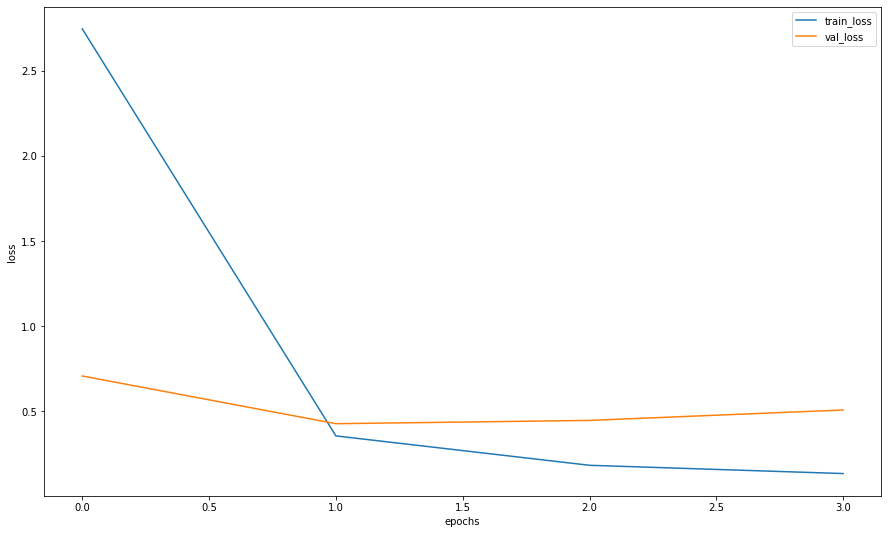

In [14]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

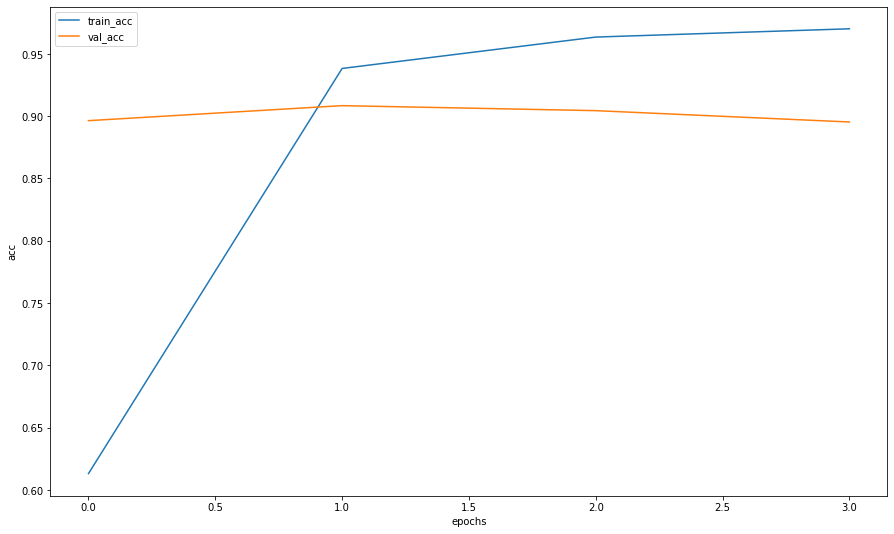

In [15]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [16]:
torch.save(model.state_dict(), 'my_model.pth')

In [17]:
c = 0
for batch in test_loader:
  c += 1
test_sizes = batch_size*c

In [18]:
def evaluate(model):
    model.eval()
    
    runninig_correct = 0
    for data in test_loader:

        inputs = data['image'].to(DEVICE)
        labels = data['label'].to(DEVICE)
            
        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / test_sizes

In [19]:
print('Accuracy of model =', evaluate(model))

Accuracy of model = 0.8834375


In [20]:
emb_model = model
emb_model.load_state_dict(torch.load('my_model.pth'))
emb_model.eval()
emb_model.to(DEVICE)
print('----------')

----------


In [21]:
print('Accuracy of model =', evaluate(emb_model))

Accuracy of model = 0.8834375


# **The accuracy of the model is approximately 88%.**

**Cosine similarity calculation**: drop a last layer of trained network. Get embeddings for some images from train set and for images from test set. Calculate cosine similarities between embeddings corresponding to the pictures of the same person and different people. Is the difference big in any of cases?

In [22]:
emb_model.classify = False

In [23]:
emb_model.eval()
with torch.no_grad():
    n1 = emb_model(train_data.get_imgs(5).to(DEVICE))
    n2 = emb_model(test_data.get_imgs(5).to(DEVICE))
    n3 = emb_model(test_data.get_imgs(14).to(DEVICE))

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

In [25]:
print(cosine_similarity(n1.cpu(), n2.cpu()).mean())
print(cosine_similarity(n1.cpu(), n3.cpu()).mean())

0.6313982
-0.049810983


**As we can see, the cosine similarity between photos of the same person -> 1 and between photots of different persons -> 0.**

**Cosine similarity distribution**: calculate all the cosine similarities between images in test dataset and train dataset of the same person. This means if you have image of person #106 in test dataset, calculate all similarities between this person's embeddings from test dataset and this person's embeddings from train dataset. 

Then also do that for pairs of different people. This means if you have image of person #106 in test dataset, calculate similarities between this person's embeddings from test dataset and other people embeddings from train dataset. 

This calculation may take a long time and memory since it's a lot of pairs. You can cut the number of pairs which you calculate distances between up to 5k, as an example.

In [26]:
import pandas as pd
cosines = []
number = 5

with torch.no_grad():
  for i in range(number):
    e1 = emb_model(train_data.get_imgs(i).to(DEVICE))
    curr = []
    for j in range(number):
      e2 = emb_model(train_data.get_imgs(j).to(DEVICE))
      curr.append(cosine_similarity(e1.cpu(), e2.cpu()).mean())
    cosines.append(curr)

rez = pd.DataFrame(np.array(cosines))

In [27]:
rez

,0,1,2,3,4
0,0.596830,-0.001092,0.001382,0.108222,-0.013547
1,-0.001999,0.575468,0.069714,-0.018515,-0.071429
2,-0.016542,0.065373,0.567995,0.035118,-0.155083
3,0.096336,-0.021033,0.035437,0.563313,-0.032112
4,-0.008253,-0.085895,-0.154746,-0.027977,0.369435


In [28]:
rez.corr().style.background_gradient(cmap='coolwarm')

,0,1,2,3,4
0,1.000000,-0.266985,-0.254815,0.117496,-0.114528
1,-0.266985,1.000000,0.117623,-0.333714,-0.426202
2,-0.254815,0.117623,1.000000,-0.094534,-0.727634
3,0.117496,-0.333714,-0.094534,1.000000,-0.233446
4,-0.114528,-0.426202,-0.727634,-0.233446,1.000000


**The cosine similarity is good: for same person's photos it tends to 1, for different persons' photos it tends to 0. So, the model works well.**

## Task 2 (20% points): Identificaton rate metric

When training the model above we used CE loss on val and test set as a measure of performance of our model. But this has a major disadvantage: we can't measure how good a model would work on unseen faces (which are not present in training, val & test sets)

To address this we can calculate another metric for the model: **identification rate**. This is how it works:

We have two sets of faces: query and distractors. None of the faces from those sets are present in train, val or test sets.

1. calculate cosine similarities between all the faces corresponding to the same people from query dataset. This means if the person has 3 photos in query part: 01.jpg, 02.jpg, 03.jpg, then calculate 3 cosine similarities between every pair of embeddings corresponding to those photos. 
2. calculate cosine similarities between all the faces corresponding to the different people from query dataset. 
3. calculate cosine similarities between all the pairs of embeddings corresponding to query and distractors. This means calculate similarities between pairs (q, d), where q is the embedding that corresponds to a face from query, d — embedding that corresponds to a face from distractors. You'll get |query|*|distractors| similarities.
4. Sum numbers of similarities from 2 and 3 stages. This is a number of false pairs.
5. fix **FPR** (false positive rate). Let it be 0.01 in our case. FPR multiplied by a number of false pairs from the stage 4 is the number of false positives we would allow our model to make. Let's call this number N
6. Sort all the similarities of false pairs by descending order. Get the Nth element from the beginning — that's our **threshold similarity**.
7. Calculate how many positive similarities from stage 1 are equal or more that threshold. Divide this number by whole number of positive similarities from stage 1. This is TPR (true positive rate) — our metric.

This metric can also be expressed as TPR@FPR=0.01. FPR can vary. 

**Task**: implement the TPR@FPR metric. Calculate it for your model and test dataset on FPR=[0.5, 0.2, 0.1, 0.05].

There're some functions pre-defined and some tests given for better understanding. Please don't change the functions prototypes, so that you can use asserts for checking.

In [32]:
!unzip -q /content/gdrive/MyDrive/celebA_ir.zip

In [29]:
! ls celebA_ir/

celebA_anno_query.txt  celebA_distractors  celebA_query


In [30]:
from collections import defaultdict

f = open('./celebA_ir/celebA_anno_query.txt', 'r')
query_lines = f.readlines()
f.close()
query_lines = [x.strip().split() for x in query_lines]

query_img_names = ['./celebA_ir/celebA_query/{}'.format(x[0]) for x in query_lines]

query_dict = defaultdict(list)
for img_name, img_class in query_lines:
  query_dict[img_class].append(img_name)

distractors_img_names = ['./celebA_ir/celebA_distractors/{}'.format(x) for x in os.listdir('./celebA_ir/celebA_distractors')]

In [31]:
class Unseenphotos(Dataset):
    def __init__(self, images_list):
        self.images = images_list
        self.transform = transforms.Compose([
                                  transforms.Resize(160),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
    
    def __len__(self):
        return len(self.images)
    
    def get_tensors(self):
        images = torch.stack([self.transform(Image.open(img_name)) for img_name in self.images])
        return images

In [32]:
def compute_embeddings(model, images_list):
  data = Unseenphotos(images_list)

  model.to(DEVICE)
  batch_size = 32
  data_loader = torch.utils.data.DataLoader(data.get_tensors(), batch_size=batch_size, shuffle=False)

  if len(images_list) != 0:
      model.eval()
      embs = []
      with torch.no_grad():
          for x in data_loader:
              outs = model(x.to(DEVICE))
              embs.append(outs.cpu())
      return torch.cat(embs)
  else:
      raise NotImplementedError

In [33]:
print(len(query_img_names), len(distractors_img_names))

7198 23397


In [34]:
query_embeddings = compute_embeddings(emb_model, query_img_names)

In [35]:
distractors_embeddings = compute_embeddings(emb_model, distractors_img_names[:10000])

In [36]:
# Unfortunately, the amount of my RAM is exhausted, so I decided to take less than a half of distractors images.

In [37]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

In [38]:
# Big part of the next functions was borrowed from the interent: github, different sites, etc.

In [39]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):

  for person_class in query_dict:
      if query_dict[person_class][0] not in query_img_names:
          PATH = './celebA_ir/celebA_query/{}'
      else:
          PATH = '{}'
      break

  full_embeddings = torch.Tensor()

  for person_class in query_dict:
      images = [PATH.format(x) for x in query_dict[person_class]]
      person_embeddings = []
      for image_path in images:
          person_embeddings.append(
              torch.Tensor(query_embeddings[query_img_names.index(image_path)])
          )
      if len(person_embeddings) == 0:
          person_embeddings = torch.Tensor
          result = 0.0
      else:
          person_embeddings = torch.stack(person_embeddings)
          result = cosine_similarity(np.array(person_embeddings), np.array(person_embeddings))
          df = pd.DataFrame(result)

          df = df.mask(np.tril(np.ones(df.shape, dtype=np.bool_))).values.reshape(-1)

          useful_result = df[~np.isnan(df)]

          useful_result = torch.Tensor(useful_result).view(-1)
          full_embeddings = torch.cat((full_embeddings, useful_result))

  results = [i.item() for i in full_embeddings]
  plt.hist(results)
  plt.show()
  print(f'Number of embeddings = {len(results)}')
  return results

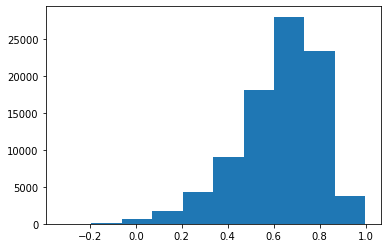

Number of embeddings = 88952


In [40]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, query_embeddings)

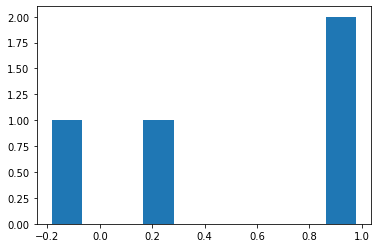

Number of embeddings = 4


In [41]:
test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names, 
                                            test_query_embeddings)

In [42]:
def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    for person_class in query_dict:
        if query_dict[person_class][0] not in query_img_names:
            PATH = './celebA_ir/celebA_query/{}'
        else:
            PATH = '{}'
        break

    full_embeddings = torch.Tensor()
    class_counter = []

    k = 0
    for person_class in query_dict:
        k += 1
        images = [PATH.format(x) for x in query_dict[person_class]]
        class_counter.extend([person_class for i in range(len(images))])

        person_embeddings = []
        for image_path in images:
            person_embeddings.append(
                torch.Tensor(query_embeddings[query_img_names.index(image_path)])
            )
        if len(person_embeddings) == 0:
            person_embeddings = torch.Tensor
            result = 0.0
        else:
            person_embeddings = torch.stack(person_embeddings)
            full_embeddings = torch.cat((full_embeddings, person_embeddings))

    all_data = pd.DataFrame(data={'class': class_counter, 'embeddings': list(full_embeddings)})
    results = cosine_similarity(full_embeddings, full_embeddings)                                                                                                                                                   
    results = pd.DataFrame(data=results, index=class_counter, columns=class_counter)

    k = 0
    for i in results:
        k += 1
        results.loc[i, i] = np.nan
    
    df = results.mask(np.tril(np.ones(results.shape, dtype=np.bool_))).values.reshape(-1) 
    useful_result = df[~np.isnan(df)]
    plt.hist(useful_result)
    plt.show()
    print('Cosine similarities =', useful_result)
    print('Number of cosine similarities =', len(useful_result))
    return useful_result

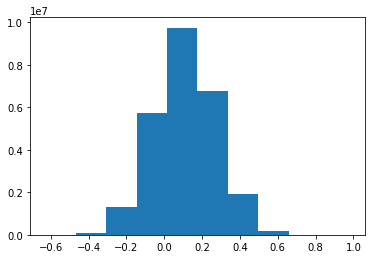

Cosine similarities = [-0.01003607  0.07103823 -0.00177181 ...  0.3814399   0.23899695
  0.39027908]
Number of cosine similarities = 25813051


In [43]:
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names, query_embeddings)

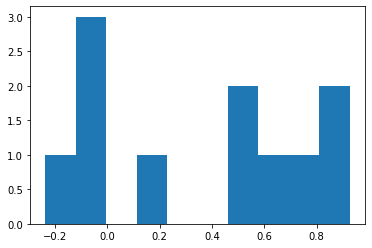

Cosine similarities = [ 0.15963231  0.85079974  0.92727613 -0.06439941  0.54126614  0.7013071
 -0.23725756  0.69410324  0.5494254  -0.01198273 -0.04666791]
Number of cosine similarities = 11


In [44]:
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names, test_query_embeddings)

In [45]:
def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    results = cosine_similarity(query_embeddings, distractors_embeddings)
    results = results.reshape(-1)
    plt.hist(results)
    plt.show()
    print('Number of cosine similarities =', len(results))
    return results

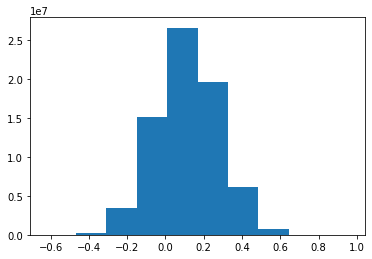

Number of cosine similarities = 71980000


In [46]:
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, distractors_embeddings)

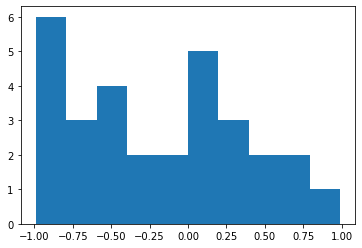

Number of cosine similarities = 30


In [47]:
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings, test_distractors_embeddings)

Implement the final function: identification rate calculation

In [48]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=0.1):
    cosine_query_pos = torch.Tensor(cosine_query_pos)
    cosine_query_neg = torch.Tensor(cosine_query_neg)
    cosine_query_distractors = torch.Tensor(cosine_query_distractors)

    false_pairs = torch.cat((cosine_query_neg, cosine_query_distractors))
    N = round(fpr * len(false_pairs))
    false_pairs = torch.sort(false_pairs, descending = True)[0]
    threshold = false_pairs[N]
    TPR = len(cosine_query_pos[cosine_query_pos > threshold]) / len(cosine_query_pos)
    return threshold.item(), TPR

Check yourself:

In [49]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg, 
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

print(test_thr)
print(test_tpr)

[-0.01198272779583931, 0.3371426463127136, 0.7013071179389954]
[0.75, 0.5, 0.5]


In [50]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

Finally compute tpr for faces query and distractors dataset and fpr = [0.5, 0.2, 0.1, 0.05]:

In [51]:
final_thr = []
final_tpr = []
for fpr in [0.5, 0.2, 0.1, 0.05]:
    x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg, 
                      test_cosine_query_distractors, fpr=fpr)
    final_thr.append(x)
    final_tpr.append(y)


print(final_thr)
print(final_tpr)

[-0.01198272779583931, 0.541266143321991, 0.7013071179389954, 0.8507997393608093]
[0.75, 0.5, 0.5, 0.5]


## Task 3 (50% points): Loss functions

Building a network on task 1 we used an ordinary CE loss. But there are many more variants of loss functions that can be used to train neural network. We will discuss two of them, which are the most popular. More examples of losses for face recognition and their performance reviews you can find in this paper: https://arxiv.org/pdf/1901.05903.pdf

### TripletLoss (25% points)

This is another kind of loss which does not require a model to have last classification layer — it works directly with embeddings. It requires by design to make embeddings of one person be close on embeddings space and embeddings of different people be far away from each other. 

This loss has an advantage over CE-like losses: it does not rely on number of classes in dataset. If we have new faces of new people in a dataset, we won't need to completely retrain the network, we could just fine-tune the trained network on new photos.


**How TripletLoss works**:

Here the architecture of neural network will be slightly different than it was when we used CE loss: it won't have the last classification layer. The last layer of NN will output embeddings of the given photo. 

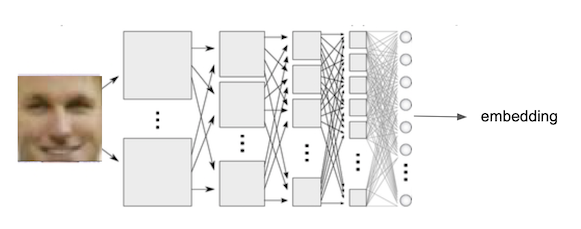

The TripletLoss function works directly with these embeddings. The idea of it is to make embeddings of the same people more close, compact in the embedding space, and the embeddings of the different people be more separate. There's a formula for the loss:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

where 
- $e$ is embedding of a photo (output of a model)
- $p$ is a positive embedding for the photo (embedding that we want $e$ be close to)
- $n$ is a negative embedding for the photo (embedding that we want $e$ be far from)
- $d(x, y)$ is a distance measure between embeddings 
- margin — a positive margin to further boost the difference between $d(a, p)$ and $d(a, n)$

**All the embeddings $e$, $p$ and $n$ must be normalized before passing them to the loss**.

In our case for the given photo $E$ and it's embedding $e$ positive embedding $p$ must be an embedding of the photo of the same person and embedding $n$ must be an ambedding of the photo of the different person.

This emplementation of TripletLoss for PyTorch can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss). There are different variants of TripletLoss which can also boost performance and which you can implement by yourself, if you want:
- use more that 1 sample of $p$ and $n$ for one embedding $e$ 
- use special kinds of negatives: e.g. the negatives that are the most close to e (to boost them be further away from e)


**More to read about TripletLoss**:

The idea of TripletLoss: https://en.wikipedia.org/wiki/Triplet_loss

PyTorch implementation of TripletLoss: https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss

**Task**: implement a model and train it with TripletLoss. Play with margin parameter to achieve better results.

Which loss among which you have tried is the best?

**To get the full mark for this task you need to train a model using  TripletLoss correctly at least for one value of margin and achieve >=75% acc on test set.** 
As we don't have a classification layer in our network, we need a custom procedure for accuracy calculation. You can use one of the following procedures:
- calculate accuracy on val and test sets using KNN with embeddings from training set as training points. (easy way)
- compute mean embeddings for every class from training set and use them as reference embeddings. Then for every embedding v from val and test sets calculate cosine similarities between v and mean embeddings from train set. (the more "right" way, but requires code writing)

You can use any of those two variants.

**Hints**:
- think of what the distance function $d$ should be in our case: training a model we want it to output embeddings which can be compared using cosine similarity function. Pay attention to that cosine similarity is not a distance measure — the more cosine distance, the closer embeddings are. Think how you can put cosine distance into TripletLoss function.
- to train model using this loss you'll need to rewrite the Dataset class so it gives you not the random image and its label, but the image, positive images and negative images for this image;
- don't forget to normalize embeddings for the loss! You may even do that by adding batchnorm/layernorm to the last layer of your network

In [ ]:
# YOUR CODE HERE -

### ArcFace Loss (Additive Angular Margin Loss) (25% points)

This loss is somewhat "SOTA" for face recognition systems (somewhat — because actually different variants of losses and their combinations may be the best for different network architectures). This loss inherits idea from CE loss but further develops it to achieve better embeddings distribution on a sphere. It introduces some geodesic constraints to enhance intra-class compactness and inter-class discrepancy.



**How ArcFace loss works**:

This loss is a variation of a standard SoftMax CE loss, which enforces embeddings of different classes (people) be further away: have a more sparse representation of embeddings in embedding space, enforce more evident gap between the nearest classes.

The standard SoftMax CE loss for classification task is presented as follows:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

where:
- $x_i \in \mathbb{R^d}$ denotes the deep feature of the $i$-th sample, belonging to the $y_i$-th class;
- $W_j \in \mathbb{R^d}$ denotes the j-th column of the weight;
- $W \in \mathbb{R^d}$ and $b_j \in \mathbb{R^d}$ is the bias term;
- $N$ — batch size;
- $n$ — class number.

It appears, that, though this loss works well, it does not explicitly optimise the feature embedding to enforce higher similarity for intra- class samples and diversity for inter-class samples, which results in a performance gap for deep face recognition under large intra-class appearance variations.

Let's do some work on this loss formula:
- fix the bias $b_j=0$;
- normalize weight ||$W_j$|| = 1;
- normalize embedding ||$x_i$|| = 1 and re-scale it to s (s is a hyperparameter)

The normalisation step on embeddings and weights makes the predictions only depend on the angle between the embedding and the weight. The learned embeddings fare thus distributed on a hypersphere with a radius of s.

So we get the following loss function now:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Final step: let's add an additive angular margin penalty $m$ between $x_i$ and $W_{y_i}$ to simultaneously enhance the intra-class compactness and inter-class discrepancy:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

SO this is an ArcFace loss. It has 2 hyperparameters: s and m.

The original paper to read about ArcFace more precisely: https://arxiv.org/pdf/1801.07698.pdf

The original repo, where you can find a code sample: https://github.com/deepinsight/insightface

**Task**: implement a model and train it with ArcFace loss. Play with ArcFace loss parameters and see if you can beat a model with CE loss.

To get the full mark for this task you need to train a model using TripletLoss correctly at least for one value of margin and achieve >=75% acc on test set.

In [ ]:
# YOUR CODE HERE -

**That's all. Thank you for your wonderful course!**